# BDA3 - Machine Learning with Spark

Implement in $\text{Spark}^1$ (PySpark) a kernel method to predict the hourly temperatures for a date and place in Sweden. To do so, you should use the files `temperature-readings.csv` and `stations.csv`. Specifically, the forecast should consist of the predicted temperatures from 4 am (04:00) to 12 am (00:00) in an interval of 2 hours for a date and place in Sweden. Use a kernel that is the sum of three Gaussian kernels:
- The first to account for the distance from a station to the point of interest.
- The second to account for the distance between the day a temperature measurement was made and the day of interest.
- The third to account for the distance between the hour of the day a temperature measurement was made and the hour of interest. Choose an appropriate smoothing coefficient or width for each of the three kernels above. You do not need to use cross-validation.

¹ Do not use SparkSQL

## Questions

1. Show that your choice for the kernels’ width is sensible, i.e. it gives more weight to closer points. Discuss why your definition of closeness is reasonable.
2. It is quite likely that the predicted temperatures do not differ much from one another. Do you think that the reason may be that the three Gaussian kernels are independent one of another? If so, propose an improved kernel, e.g. propose an alternative way of combining the three Gaussian kernels described above.

## Help

- Note that the file `temperature-readings.csv` may contain temperature measurements that are posterior to the day and hour of your forecast. You must filter such measurements out, i.e. they cannot be used to compute the forecast.
- Cache the data you will reuse by using `rdd.cache()`. Check the course slides.
- Avoid joining two RDDs. Instead, broadcast the smallest, if small enough. Check the course slides.
- My program takes 5-6 minutes (wallclock) on the whole temperature-readings.csv. However, you may want to use a sample when implementing and testing different settings. Then, do `rdd.sample(False, 0.1)` to obtain a sample without replacement of size 10%.
- Feel free to use the template below to solve the assignment.

## Implementation

---

In [1]:
import pyspark
import datetime
from math import exp
import helpers
import time

# Log execuation time. %%time does not with the Jupyter Lab provided by anaconda for the pyspark environment
start_time = time.time()

# Data paths
tr_path = "../../../data/temperature-readings.csv"
sr_path = "../../../data/stations.csv"

# Spark content and data import
global sc
sc = pyspark.SparkContext(appName="Temperature")

# Temperatures pre processing
temperature_readings = sc.textFile(tr_path)
# station-id, year, month, day, hour, minute, second, temperature
# [(102170, 2013, 11, 1, 6.0, 0.0, 0.0, 6.0)]
temperatures = temperature_readings.map(lambda l: l.split(";"))
temperatures = temperatures.map(lambda m: (int(m[0]),
                                           int(m[1].split("-")[0]),
                                           int(m[1].split("-")[1]),
                                           int(m[1].split("-")[2]),
                                           float(m[2].split(":")[0]),
                                           float(m[2].split(":")[1]),
                                           float(m[2].split(":")[2]),
                                           float(m[3])))

# Stations pre processing
station_readings = sc.textFile(sr_path)
stations = station_readings.map(lambda l: l.split(";"))
# station-id, latitude, longitude
# [(102170, 60.2788, 12.8538)]
stations = stations.map(lambda m: (int(m[0]), (float(m[3]), float(m[4]))))

# General parameters
h_distance = 150
h_date = 30
h_time = 3

# Function call parameters
#latitude = 58.4166
#longitude = 15.6333
#date = datetime.date(2000, 5, 8)
latitude = 55.3836
longitude = 12.8203
date = datetime.date(2004, 5, 28)


def gaussian_kernel(value, smoothing):
    """
    Implementation of the gaussian kernel.
    :param value: The value for which the kernel should be applied.
    :param smoothing: The smoothing factor h to apply.
    :return: The gaussian kernel applied to the given value.
    """
    return exp(-(value/smoothing)**2)


def min_distance(a, b, ring_size):
    """
    Calculates the shortest distance on a ring between two points.
    :param a: Point a.
    :param b: Point b.
    :param ring_size: Size of the ring
    :return: The shortest difference between a and b on the given 1-dimensional ring.
    """
    if a < 0 or a > ring_size or b < 0 or b > ring_size:
        raise ValueError("Both arguments must be greater or equal to 0 and smaller or equal to ring_size.")
    return min(abs(a - b), ring_size - abs(a - b))


def kernel_distance(location, rdd_temperatures, rdd_stations, smoothing, kernel):
    """
    Calculates all distances from the location to the locations in the supplied RDD.
    :param location: The given location.
    :param rdd_temperatures: An RDD with the first entry being the latitude and the second entry the longitude.
    :param rdd_stations: An RDD where the first entry is a tuple or list containing latitude and longitude.
    :param smoothing: Smoothing factor for the supplied kernel.
    :param kernel: A kernel function.
    :return: Returns all distances from location to all locations found in rdd_temperatures.
    """
    distances = rdd_temperatures.map(lambda m: helpers.haversine(location[0],
                                                                 location[1],
                                                                 rdd_stations.value[m[0]][0],
                                                                 rdd_stations.value[m[0]][1]))
    distances = distances.map(lambda m: kernel(m, smoothing))
    return distances


def kernel_day(day, rdd, smoothing, kernel):
    """
    Calculates all distances from the given day to all dates in the supplied RDD.
    :param day: A datetime object specifying the day of the year.
    :param rdd: An RDD where m[1:3] contain year, month and day.
    :param smoothing: Smoothing factor for the supplied kernel.
    :param kernel: A kernel function.
    :return: Returns all distances from day to all days found in RDD.
    """
    differences = rdd.map(lambda m: min_distance(datetime.date(m[1], m[2], m[3]).timetuple().tm_yday,
                                                 day.timetuple().tm_yday, 366))
    differences = differences.map(lambda m: kernel(m, smoothing))
    return differences


def kernel_hour(hour, rdd, smoothing, kernel):
    """
    Calculates all distances from the given hour to all hours in the supplied RDD.
    :param hour: A datetime object specifying the hour of the day.
    :param rdd: An RDD where m[4] is the hour of the day.
    :param smoothing: Smoothing factor for the supplied kernel.
    :param kernel: A kernel function.
    :return: Returns all distances from hour to all hours found in RDD.
    """
    differences = rdd.map(lambda m: min_distance(hour.timetuple().tm_hour, m[4], 24))
    differences = differences.map(lambda m: kernel(m, smoothing))
    return differences


def predict_weather(latitude,
                    longitude,
                    predict_date,
                    rdd_temperatures,
                    rdd_stations,
                    h_distance,
                    h_date,
                    h_time,
                    kernel,
                    include_product=False):
    """
    Predicts the weather for the given day.
    :param latitude: Latitude of the desired location.
    :param longitude: Longitude of the desired location.
    :param predict_date: The date where to predict the weather.
    :param rdd_temperatures: An RDD containing temperature information. Check documentation on course page.
    :param rdd_stations: An RDD containing station information. Check documentation on course page.
    :param h_distance: Smoothing factor for the distance.
    :param h_date: Smoothing factor for the date.
    :param h_time: Smoothing factor for the time.
    :param kernel: A kernel function.
    :param include_product: Specifies if the product of the kernels should also be calculated. Default is 'False'.
    :return: Returns a list with the predicted temperature for all even hours of the given date.
    """
    # Remove all future data and cache data
    rdd_temperatures = rdd_temperatures.filter(lambda m: datetime.date(m[1], m[2], m[3]) > predict_date).cache()
    # Collect as a dictionary
    rdd_stations = rdd_stations.collectAsMap()
    # Broadcast to make available
    rdd_stations = sc.broadcast(value=rdd_stations)

    # Create the data points distributed over the day
    hours = (4, 6, 8, 10, 12, 14, 16, 18, 20, 22)
    daytimes = [datetime.datetime.combine(predict_date, datetime.time(hour, 0)) for hour in hours]
    daytimes.append(datetime.datetime.combine(predict_date + datetime.timedelta(days=1), datetime.time(0, 0)))

    # Call the different kernel functions

    # Distance difference
    kernel_distances = kernel_distance((latitude, longitude), rdd_temperatures, rdd_stations, h_distance,
                                       kernel)

    # Day difference
    kernel_days = kernel_day(predict_date, rdd_temperatures, h_date, kernel)

    # Hour difference
    kernel_hours = [kernel_hour(daytime, rdd_temperatures, h_time, kernel) for daytime in daytimes]
    
    ########################## TEMP ##########################
    
    #return (kernel_distances.take(100), kernel_days.take(100), kernel_hours[0].take(100))
    
    ########################## TEMP END ##########################

    # Combine fixed kernels
    kernel_distance_days_sum = kernel_distances.zip(kernel_days).map(lambda m: sum(m)).cache()

    if include_product:
        kernel_distance_days_prod = kernel_distances.zip(kernel_days).map(lambda m: helpers.prod(m)).cache()

    # For storing the predictions
    temperature_predictions = [None] * len(daytimes)

    for i in range(0, len(daytimes)):

        # Add the non fixed kernel (moving over day)
        kernel_sum = kernel_distance_days_sum.zip(kernel_hours[i]).map(lambda m: sum(m))

        # Include the temperatures for calculations
        res_sum = kernel_sum.zip(rdd_temperatures).map(lambda m: (m[0], m[1][7]))

        # Apply the formulas from slides
        res_sum = res_sum.map(lambda m: (m[0] * m[1], m[0]))
        res_sum = res_sum.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))

        if include_product:

            # Add the non fixed kernel (moving over day)
            kernel_prod = kernel_distance_days_prod.zip(kernel_hours[i]).map(lambda m: helpers.prod(m))

            # Include the temperatures for calculations
            res_prod = kernel_prod.zip(rdd_temperatures).map(lambda m: (m[0], m[1][7]))

            # Apply the formulas from slides
            res_prod = res_prod.map(lambda m: (m[0] * m[1], m[0]))
            res_prod = res_prod.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))

        # Store the result
        result = [res_sum[0] / res_sum[1]]

        if include_product:
            result.append(res_prod[0] / res_prod[1])

        temperature_predictions[i] = result

    return temperature_predictions


predicted_temperatures = predict_weather(latitude, longitude, date, temperatures, stations,
                                         h_distance, h_date, h_time, gaussian_kernel, True)

global res
res = predicted_temperatures

# Close Spark context
sc.stop()

# Print execution time
print("--- %s seconds ---" % (time.time() - start_time))

--- 1189.7563726902008 seconds ---


In [2]:
res

[[6.299695354408612, 10.689411256168619],
 [6.625032905563868, 12.089992902801033],
 [7.218366170074819, 13.641101520001937],
 [7.830206770906536, 14.962593838591108],
 [8.177287679932158, 15.675200865698502],
 [8.183737849621584, 15.71082120556548],
 [7.867516885675942, 15.077676112929126],
 [7.40054224075679, 13.934025820456583],
 [6.966576493436545, 12.469466769020405],
 [6.606287735971103, 11.052459376312909],
 [6.348557787857218, 10.138210059791328]]

In [3]:
temp_pred_sum = [r[0] for r in res]
temp_pred_prod = [r[1] for r in res]

In [4]:
import pandas as pd

data = {'hour':[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
        'temperature-prediction-sum':temp_pred_sum,
        'temperature-prediction-prod':temp_pred_prod} 
  
df = pd.DataFrame(data) 

In [5]:
df

,hour,temperature-prediction-sum,temperature-prediction-prod
0,4,6.299695,10.689411
1,6,6.625033,12.089993
2,8,7.218366,13.641102
3,10,7.830207,14.962594
4,12,8.177288,15.675201
5,14,8.183738,15.710821
6,16,7.867517,15.077676
7,18,7.400542,13.934026
8,20,6.966576,12.469467
9,22,6.606288,11.052459


In [6]:
df.reset_index(level=0, inplace=True)

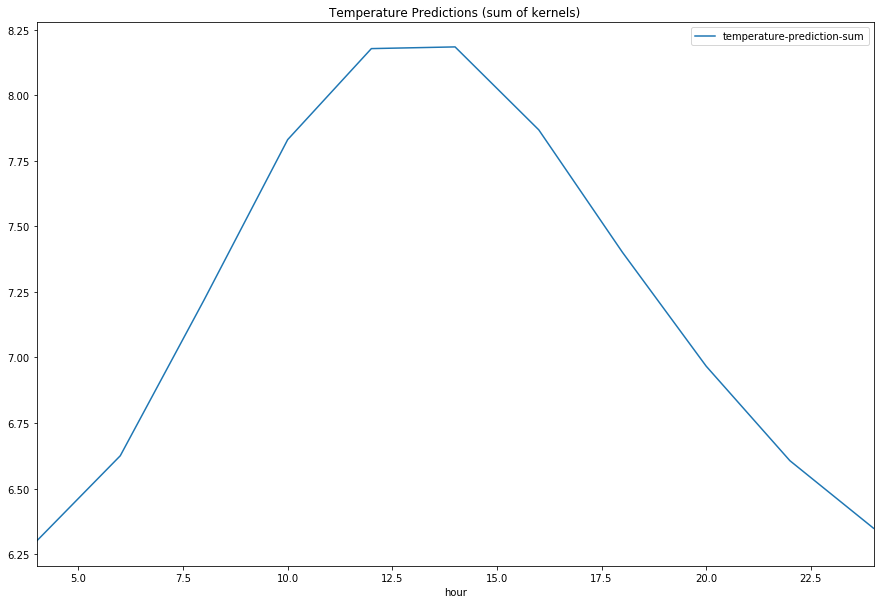

In [8]:
df.plot.line(x = 'hour', y = 'temperature-prediction-sum', figsize=(15,10), title = "Temperature Predictions (sum of kernels)");

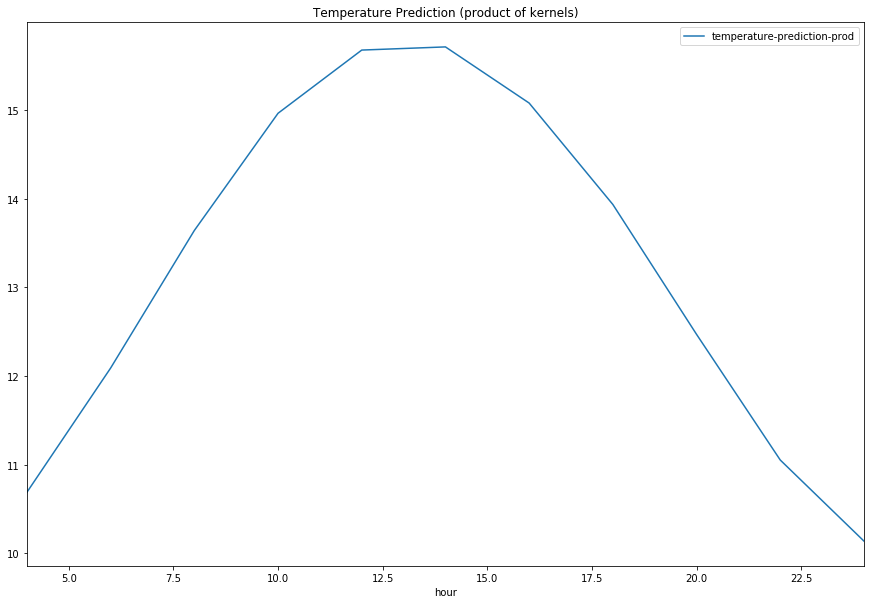

In [9]:
df.plot.line(x = 'hour', y = 'temperature-prediction-prod', figsize=(15,10), title = "Temperature Prediction (product of kernels)");

# Question 1

**Show that your choice for the kernels’ width is sensible, i.e. it gives more weight to closer points. Discuss why your definition of closeness is reasonable.**

---

**Answer**

In order to show that our choice for the kernel's width is sensible, we plot the three Gaussian Kernels with their respective smoothing factors (i.e. kernel widths) for certain sequences of distance values. Based on the plots, we can then judge whether the Kernel gives appropriate weights to the distance values.

The three plots below show the following (respectively):

- Gaussian Kernel by Geografic distance (in km)
- Gaussian Kernel by Day distance (in days)
- Gaussian Kernel by Time distance (in hours)

We see that the weights given to certain distance values do seem sensible, i.e. reasonable:

- For the geografic distance, it seems reasonable to give an almost 0 weight for temperature measurements more than 300km away from the target case. This is because e.g. a thunderstorm or rain clouds will likely not cover a region larger than 300km. Likewise, it seems to make sense that temperatures up to ca. 100km away get a relatively high weight with values larger than 0.5 (see plot), assuming that in an area with a 100km radius we have somewhat similar temperatures.
- For the day distance, it seems reasonable to give an almost 0 weight for temperature measurements more than 60 days away from the target case. This is because e.g. August and Oktober (a two month differerence represented by the 60 days) may have noticeable different temperatures. Likewise, it seems to make sense that temperatures up to ca. 25 days away get a relatively high weight with values larger than 0.5 (see plot), assuming that in a time period of 1 month, we have somewhat similar temperatures.
- For the time distance, it seems reasonable to give an almost 0 weight for time measurements more than 6 hours away from the target case. This is because e.g. temperatures may be noticeably different for 18:00 and 24:00 (a 6 hour difference). Likewise, it seems to make sense that temperatures up to ca. 2.5 hours away from the target case get a relatively high weight with values larger than 0.5 (see plot), assuming that in a time period of 2.5 hours, we have somewhat similar temperatures.

In [28]:
# Chosen Kernel widths (see implementation)
h_distance = 150
h_date = 30
h_time = 3

# Gaussian Kernel (see implementation)
def gaussian_kernel(value, smoothing):
    """
    Implementation of the gaussian kernel.
    :param value: The value for which the kernel should be applied.
    :param smoothing: The smoothing factor h to apply.
    :return: The gaussian kernel applied to the given value.
    """
    return exp(-(value/smoothing)**2)


# Vectorized Version of Gaussian Kernel (for numpy)
np_gaussian_kernel = np.vectorize(gaussian_kernel)
np_gaussian_kernel.__name__ = "np_gaussian_kernel"

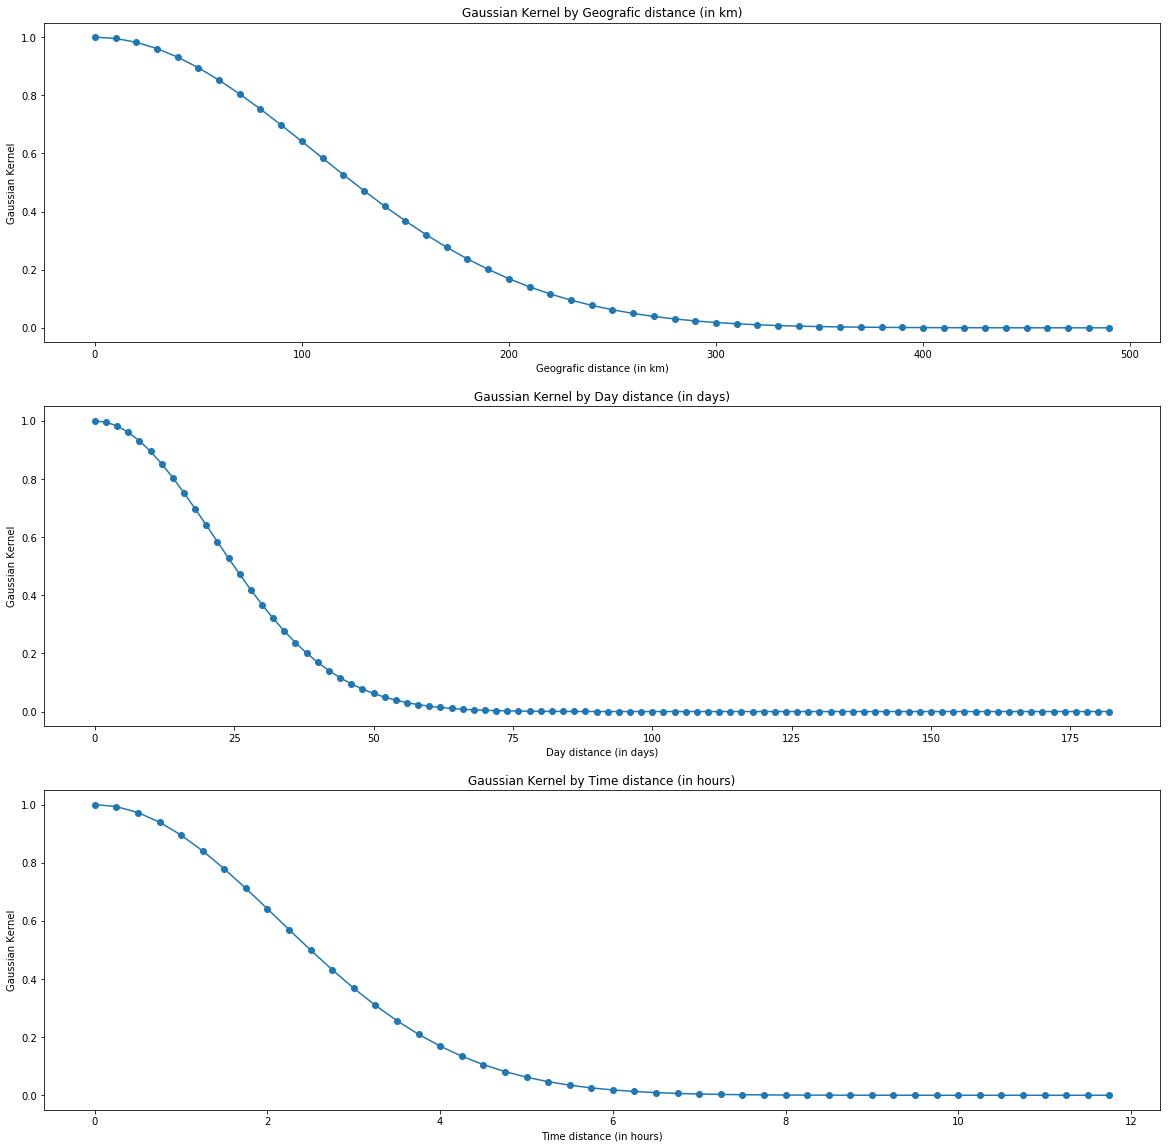

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp

plt.rcParams["figure.figsize"] = (20,20)

x1 = np.arange(0, 500, 10)
x2 = np.arange(0, 183, 2)
x3 = np.arange(0, 12, 0.25)

y1 = np_gaussian_kernel(x1, h_distance)
y2 = np_gaussian_kernel(x2, h_date)
y3 = np_gaussian_kernel(x3, h_time)

plt.subplot(3, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Gaussian Kernel by Geografic distance (in km)')
plt.xlabel('Geografic distance (in km)')
plt.ylabel('Gaussian Kernel')

plt.subplot(3, 1, 2)
plt.plot(x2, y2, 'o-')
plt.title('Gaussian Kernel by Day distance (in days)')
plt.xlabel('Day distance (in days)')
plt.ylabel('Gaussian Kernel')

plt.subplot(3, 1, 3)
plt.plot(x3, y3, 'o-')
plt.title('Gaussian Kernel by Time distance (in hours)')
plt.xlabel('Time distance (in hours)')
plt.ylabel('Gaussian Kernel')

plt.show()

# Question 2

**It is quite likely that the predicted temperatures do not differ much from one another. Do you think that the reason may be that the three Gaussian kernels are independent one of another?
If so, propose an improved kernel, e.g. propose an alternative way of combining the three Gaussian kernels describe dabove.**

---

**Answer**



In the implementation we used two different approaches for combining the Kernel: sum and product. The sum indeed seems to imply that the different Kernels are independent of each other. In other words, we assume that the temperature only changes by geografic distance, by day distance and by time distance individually - but not due to an interaction of day and time, day and distance, time and distance or day, time and distance. Now, does this make sense? Consider a temperature measurement with a small day distance of 1 and a small geografic distance of 1 *but* a large hour distance of 12. With the summation, we would ultimately still give a quite high weight to this temperature measurement because the geografic and the day distance Kernels would give high weights and these would contribute to the aggregated Kernel noticeably since we use a summation operation. However, this temperature measurement may be in the middle of the night (whereas the target measurement would be at noon). It's much colder in the night than at noon. Consequently, we do not think that this temperature measurement should actually get a high weight.

In reality, we would like to give high weights to temperature measurements that have high weights from all three Kernels. If one Kernel gives a
zero or almost zero weight, we would also want the aggregated Kernel to give a small weight (see example above). Therefore, we would rather **prefer to combine the Kernels with a product**. This will make sure that only relevant (i.e. fewer) temperature measurements will really contribute to the prediction. This is because if one Kernel has a zero value, the aggregated Kernel will give a zero value due to the multiplication operation. Since fewer measurements contribute, we are less likely to get similar temperature predictions for different time points during the day. Lastly, we can also see from the plots in the implementation section that the predictions with the product make more sense than the predictions with the summation. In May, the temperatures are rather close to 15 degrees celsius during the day (than 8 degrees celsius).